# 00 — Orientation Demos

This notebook gives quick, visual intuition for key concepts before we dive deeper:
- Loss functions (MSE, BCE) and their behavior
- Gradient descent basics (with/without momentum)
- Gradient clipping
- Adam vs SGD on a curved surface
- Softmax + cross-entropy with numerical stability

> Tips: Run each cell top-to-bottom. One chart per cell to keep things clean.


In [2]:
# Imports & Utilities
import math
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)

def plot_setup(title=None, xlabel=None, ylabel=None):
    plt.figure()
    if title: plt.title(title)
    if xlabel: plt.xlabel(xlabel)
    if ylabel: plt.ylabel(ylabel)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(z):
    # stable softmax
    z = z - np.max(z, axis=-1, keepdims=True)
    exp = np.exp(z)
    return exp / np.sum(exp, axis=-1, keepdims=True)

def cross_entropy_from_logits(logits, y_idx):
    # y_idx: integer class labels
    # stable log-softmax trick
    logits = logits - np.max(logits, axis=-1, keepdims=True)
    log_probs = logits - np.log(np.sum(np.exp(logits), axis=-1, keepdims=True))
    N = logits.shape[0]
    return -np.mean(log_probs[np.arange(N), y_idx])


## 1) Loss landscapes: MSE vs BCE
Two toy demos to feel how the losses behave as predictions move.

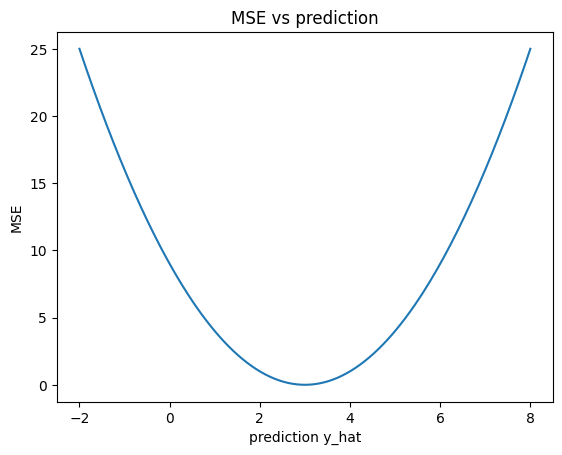

In [3]:
# 1A. MSE vs prediction error on a single sample
y_true = 3.0
y_hat = np.linspace(-2, 8, 200)
mse = (y_true - y_hat)**2

plot_setup("MSE vs prediction", "prediction y_hat", "MSE")
plt.plot(y_hat, mse)
plt.show()


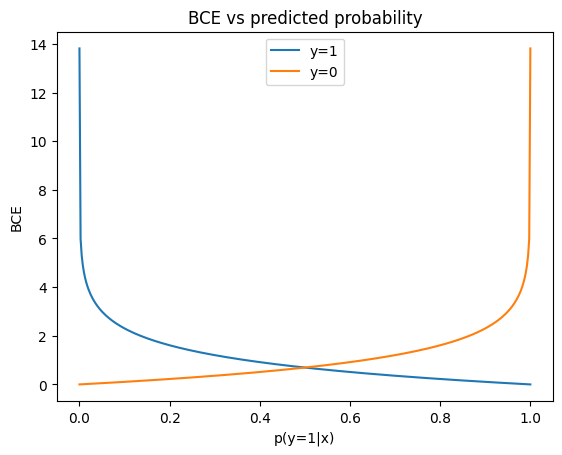

In [5]:
# 1B. Binary Cross Entropy (BCE) vs predicted probability for y in {0,1}
p = np.linspace(1e-6, 1-1e-6, 400)
bce_y1 = -np.log(p)          # y=1
bce_y0 = -np.log(1 - p)      # y=0

plot_setup("BCE vs predicted probability", "p(y=1|x)", "BCE")
plt.plot(p, bce_y1, label="y=1")
plt.plot(p, bce_y0, label="y=0")
plt.legend()
plt.show()


## 2) Gradient descent basics (with and without momentum)
We minimize a simple quadratic $f(w) = aw^2$ and visualize convergence.

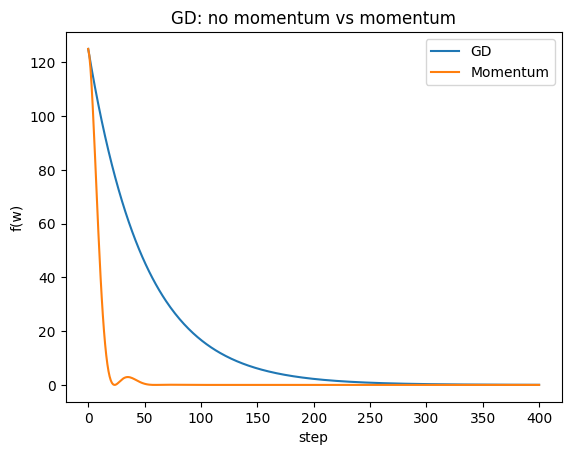

In [18]:
# Quadratic: f(w) = a w^2, grad = 2 a w
a = 5.0
def f(w): return a * (w**2)
def grad(w): return 2 * a * w

w0 = 5.0
lr = 0.001     # <— smaller LR so GD decays geometrically
steps = 400

# Plain GD
w = w0
traj_gd = [w]
for t in range(steps):
    w -= lr * grad(w)
    traj_gd.append(w)

# GD with momentum (Polyak form)
beta = 0.9
w = w0
v = 0.0
traj_m = [w]
for t in range(steps):
    v = beta * v + grad(w)   # accumulate gradient
    w = w - lr * v
    traj_m.append(w)

# Plot objective over steps
plot_setup("GD: no momentum vs momentum", "step", "f(w)")
plt.plot([f(w) for w in traj_gd], label="GD")
plt.plot([f(w) for w in traj_m], label="Momentum")
plt.legend()
plt.show()


## 3) Gradient clipping
Simulate a sequence of gradient norms and show how clipping at a threshold stabilizes updates.

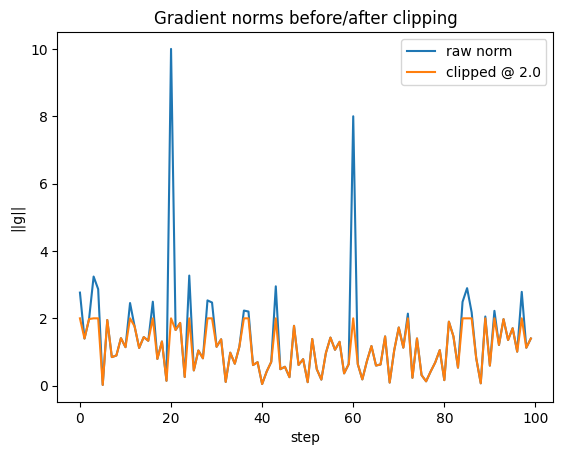

In [23]:
# Simulated gradient norms (spikes mimic 'exploding' gradients)
np.random.seed(0)
grads = np.abs(np.random.normal(loc=1.0, scale=1, size=100))
grads[20] = 10.0
grads[60] = 8.0

tau = 2.0  # clip threshold

# Clip by global norm example (per-step here)
#clipped = np.array([g * min(1.0, tau / max(g, 1e-9)) for g in grads])
clipped = grads * np.minimum(1.0, tau / np.maximum(grads, 1e-9))

plot_setup("Gradient norms before/after clipping", "step", "||g||")
plt.plot(grads, label="raw norm")
plt.plot(clipped, label=f"clipped @ {tau}")
plt.legend()
plt.show()


## 4) Adam vs SGD on a curved surface
We optimize an anisotropic quadratic $f(\mathbf{w}) = \frac{1}{2}(100w_0^2 + 0.01 w_1^2)$.
Adam adapts per-parameter steps; SGD uses a fixed step.

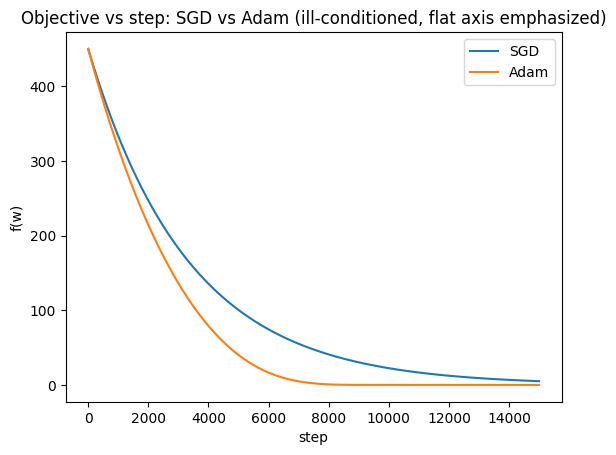

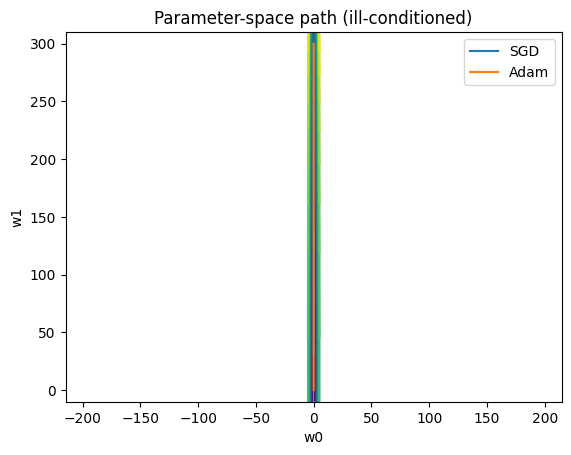

In [43]:
# Ill-conditioned quadratic
A = np.diag([100.0, 0.01])     # steep in x, flat in y
def f2(w): 
    w_col = w.reshape(w.size, 1)
    return 0.5 * (w_col.T @ A @ w_col).item()
def grad2(w): return A @ w

def sgd(w, g, lr): return w - lr * g

class Adam:
    def __init__(self, lr=0.05, beta1=0.9, beta2=0.999, eps=1e-8):
        self.lr, self.b1, self.b2, self.eps = lr, beta1, beta2, eps
        self.m = None; self.v = None; self.t = 0
    def step(self, w, g):
        if self.m is None:
            self.m = np.zeros_like(g); self.v = np.zeros_like(g)
        self.t += 1
        self.m = self.b1*self.m + (1-self.b1)*g
        self.v = self.b2*self.v + (1-self.b2)*(g*g)
        mhat = self.m / (1 - self.b1**self.t)
        vhat = self.v / (1 - self.b2**self.t)
        return w - self.lr * (mhat / (np.sqrt(vhat) + self.eps))

# Start mostly along the flat axis so it actually matters
w0 = np.array([0.0, 300.0])

steps   = 15000
lr_sgd  = 0.015             # < 2 / max_eig = 0.02 (stable)
adam    = Adam(lr=0.05)     # single Adam instance (stateful)

w_sgd = w0.copy(); w_adam = w0.copy()
sgd_traj = [w_sgd.copy()]; adam_traj = [w_adam.copy()]
for _ in range(steps):
    w_sgd  = sgd (w_sgd,  grad2(w_sgd),  lr_sgd)
    w_adam = adam.step(w_adam, grad2(w_adam))
    sgd_traj.append(w_sgd.copy()); adam_traj.append(w_adam.copy())

# Objective vs step
plot_setup("Objective vs step: SGD vs Adam (ill-conditioned, flat axis emphasized)", "step", "f(w)")
plt.plot([f2(w) for w in sgd_traj],  label="SGD")
plt.plot([f2(w) for w in adam_traj], label="Adam")
plt.legend(); plt.show()

# Path plot (wider y-range so you can see movement)
xs = np.linspace(-5, 5, 200)
ys = np.linspace(-10, 310, 400)
X, Y = np.meshgrid(xs, ys)
Z = 0.5*(100.0*X**2 + 0.01*Y**2)



## 5) Softmax + Cross-Entropy (numerical stability)
Show how the log-sum-exp trick avoids overflow when logits are large.

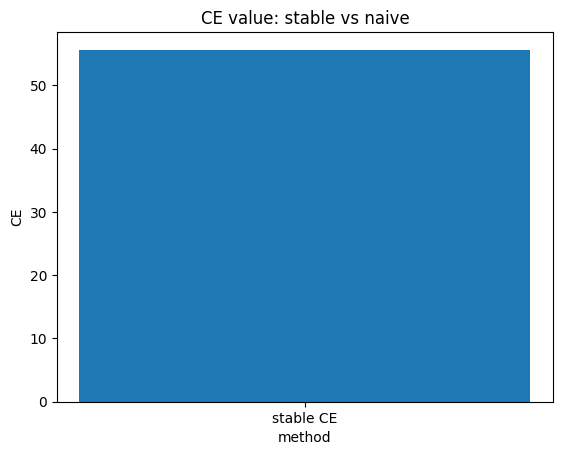

Stable CE: 55.62724092679042
Naive (may overflow) CE: 55.62724092679042 (if NaN or inf, overflow occurred)


In [44]:
# Create logits with a large scale and compute CE two ways
np.random.seed(1)
N, C = 256, 5
scale = 50.0
logits = np.random.randn(N, C) * scale
y_idx = np.random.randint(0, C, size=N)

# Unstable softmax (for illustration; try/except to avoid actual overflow crash)
def ce_unstable(logits, y_idx):
    exps = np.exp(logits)           # can overflow
    probs = exps / np.sum(exps, axis=1, keepdims=True)
    return -np.mean(np.log(probs[np.arange(len(y_idx)), y_idx]))

# Stable CE using helper
ce_stable = cross_entropy_from_logits(logits.copy(), y_idx)

unstable_val = None
try:
    unstable_val = ce_unstable(logits.copy(), y_idx)
except FloatingPointError:
    unstable_val = np.nan

plot_setup("CE value: stable vs naive", "method", "CE")
vals = [ce_stable]
labels = ["stable CE"]
# Plot only the stable value; print the naive value textually
plt.bar(labels, vals)
plt.show()

print("Stable CE:", ce_stable)
print("Naive (may overflow) CE:", unstable_val, "(if NaN or inf, overflow occurred)")
